# Whole Network Analysis

Here, we will compare the healthy network with the diseased network, looking at measures of centrality and community structure, both of which are described in this notebook

# **Centrality Analysis**

## **Introduction** - Understanding Centrality

The structure of complex networks such as PPINs are often very heterogenous and it can be expected that some proteins will be more important than others when considering functionality, and in our case, their role in disease. The importance of these proteins can be quantified by a measure of network centrality, in which the most 'central' proteins score higher in this measure and are typically the most influential over the flow of information within the network.For this study, we will consider three different definitions of what it means for a protein to be a central in our network, and use these definitions to identify important hubs and bottlenecks which may serve as targets for therapeutic intervention. For this analysis we will be using betweenness, degree, and closeness centrality, each of which are described, along with their considerations in the next section.


## Betweenness Centrality:

Using this definition of centrality, a node is central if there are many shortest paths running through it. For example, if we imagine a metabolic network composed of various enzymes which transform basic nutrients into functional proteins and suppose we identify an enzyme that catalyzes a reaction that forms an intermediate metabolite common to all final products, we would label that protein enzyme as having a high betweenness centrality. Specifically, this measure of centrality can be described in the following formula:

$$B_{i}= \sum_{a,b}\frac{\eta(a,i,b)}{\eta(a,b)}$$

where $\eta(a,i,b)$ represents the number of shortest paths connecting nodes $\textit{a}$ and $\textit{b}$ that pass through vertex $\textit{i}$ and $\eta(a,b)$ represents the total number of shortest paths that exist between $\textit{a}$ and $\textit{b}$. This calculation of $B_{i}$ can be simply understood as the summation of the proportions of the number of node pairs in the network that include i along their connecting path out of the total number of possible paths from $\textit{a}$ to $\textit{b}$. Given this, a higher $B_{i}$ value indicates the node is more central.

Identifying proteins in our network with a high $B_{i}$ should reveal bottlenecks, where two communities are linked together by a single, or few proteins. If bottleneck proteins are disrupted, the information flow between the connected communities would likely stop, resulting in large changes in the functionality of those communities.  

##  Degree Centrality:

Defining a node as central by its degree is another common way of measuring centrality. Using this definition, a node is central if it has a high degree, meaning there are many edges connecting it. This formula can be represented as: 

$$k_{i} = \sum_{j=1}^{N}A_{ij}$$

where $\textit{i}$ is the node of interest, N is the number of nodes in the network, and j is another node within the network. This definition of centrality is better used when interested in local centrality, such as identifying major general hubs. An example of this might be identifying a signal transduction factor that is implemented in a wide variety of cellular functions. A major limitation when using this definition of centrality is that the node labeled as central may exist at the periphery of the network and not actually be located in the center, topographically. 

## Closeness Centrality:

Lastly, we will be considering the closeness definition of centrality. Under this definition, a node is considered central if it is close to all other nodes in the network. This can be calculated as the average distance of each node to all other nodes and can represented as: $$C_{i} = \frac{N}{\sum_{j=1,j\neq{i}}^{N}d_{ij}}$$ 

where $C_{i}$ is the measure of centrality at a particular node i, N is the total number of nodes in the network, and $d_{ij}$ is the length of the shortest path between i and j.

This definition is intuitive in that one might expect information in a protein network to flow through the shortest distances, and works best for networks with larger variability in path length. A drawback of this working definition is that in PPINs where the variability in average pathlength is small, defining a protein as central may be meaningless if the diameter of the network is small.

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#Import healthy graph
file1 = open("../Data/Graphs/Macrophage_healthy_graph_with_cleaned_attributes.pkl", "rb")
GX = nx.read_gpickle(file1)

#import diseased graph
file2 = open("../Data/Graphs/Macrophage_diseased_graph_with_cleaned_attributes.pkl", "rb")
GZ = nx.read_gpickle(file2)

#examine
print(GX)
print(GZ)

Graph named 'Healthy Network' with 3057 nodes and 4733 edges
Graph named 'Diseased Network' with 3069 nodes and 4755 edges


In [9]:
#Define all functions used in this notebook
#Function for printing top X percent of central nodes
def percentile_puller(dct,percentile)->dict:
    """Function takes a dictionary of centrality scores and outputs a dictionary containing only the top X percent of scores"""
    central_lst = list(dct.values())
    p = np.percentile(central_lst,(100-percentile)) #returns percentile score
    percentile_dct = {}
    for key,value in dct.items():
        if dct[key] >= p:
            percentile_dct[key] = dct[key]
    return(percentile_dct)

#Function for printing useful stats on network
def graphfeatures(graph):
    """Function inputs a graph and outputs some useful statistics about it."""
    Gx = graph
    #Eccentricity of a node is the maximum distance from that node to all other nodes in the graph
    #Graph Length
    print("General graph features = {}".format(print(Gx)))

    #Graph Center (center is the set of nodes with eccentricity equal to radius)
    try: 
        print("Graph center = {}".format(nx.center(Gx)))
    except:
        print("Graph not connected, no graph center can not be calculated")


    #Graph Diameter (diameter is maximum eccentricity)
    try:
        print("Graph diameter = {}".format(nx.diameter(Gx)))
    except:
        print("Graph not connected, Diameter can not be calculated")


    #Graph Radius (minimum eccentricity)
    try:
        print("Graph Radius = {}".format(nx.radius(Gx)))
    except:
        print("Graph not connected, Radius can not be calculated")

    #Average Degree
    total_edges = len(Gx.edges())
    total_nodes = len(Gx.nodes())
    Avg_degree = total_edges/total_nodes
    print("The Average Degree of our network is {}. The average degree of a network refers to the average number of edges that exist for each node.".format(round(Avg_degree,2)))

    #Density of graph
    print("The Density of our graph is {}. Density is a measure of how many ties between nodes exist compared to how many are possible.".format(round(nx.density(Gx),4)))

    #Average clustering coefficient
    print("The average clustering coefficient of our graph is {}. The clustering coefficient ranges from 0-1 and is a measure of the ratio of connections for each node observed versus what is possible ".format(round(nx.average_clustering(Gx),4)))

    #Is the graph fully connected?
    print("Is the graph fully connected? {}".format(nx.is_connected(Gx)))

    #Number of connected components:
    print("Number of connected components = {}".format(nx.number_connected_components(Gx)))

    #Number of Isolates (no neighbors)
    isolates = len(list(nx.isolates(Gx)))
    print("Number of isolates = {}".format(isolates))

#Function for printing top X percentile of central nodes
def centralityanalysis(graph,percentile):
    """Function inputs a graph and and prints out the top X percentile of central nodes, while also returning the full ranked lists"""
    p = int(percentile)
    Gx = graph
    
    print('Centrality by percentile','\n')
    #Edge betweenness (better at finding bottlenecks)
    betweenness_centralities = nx.betweenness_centrality(Gx) #dictionary of values
    betweenness_sorted_h = dict(sorted(betweenness_centralities.items(), reverse = True, key=lambda x:x[1])) #sort it so highest centrality are at top
    top_vals_betweenness =  percentile_puller(betweenness_sorted_h,p) #Dict of top p% of nodes
    print("List of top ",p,"% most 'betweenness' central nodes and their corresponding centrality values:")
    for i in top_vals_betweenness:
        print(i, ':\t', top_vals_betweenness[i])

    #Closeness
    Closeness_centralities = nx.closeness_centrality(Gx)
    Closeness_sorted_h = dict(sorted(Closeness_centralities.items(), reverse = True, key=lambda x:x[1]))
    top_vals_closeness =  percentile_puller(Closeness_sorted_h,p) #Dict of top p% of nodes
    print("List of top ",p,"% most 'closeness' central nodes and their corresponding centrality value:")
    for i in top_vals_closeness:
        print(i, ':\t', top_vals_closeness[i])

    #Degree centrality 
    Degree_centralities = nx.degree_centrality(Gx)
    Degree_sorted = dict(sorted(Degree_centralities.items(), reverse = True, key=lambda x:x[1])) #sort it so highest centrality are at top
    top_vals_degree =  percentile_puller(Degree_sorted,p) #Dict of top p% of nodes
    print("List of top ",p,"% most 'degree' central nodes and their corresponding centrality value:")
    for i in top_vals_degree:
        print(i, ':\t', top_vals_degree[i])
    
    return(betweenness_sorted_h, Closeness_sorted_h, Degree_sorted)

#Function to print distribution of scores
def centrality_distrib_plot(dct,xlab):
    """Function takes a sorted centrality dictionary and prints a distribution of the scores."""
    centrality_list = [] 
    xlab = str(xlab)
    for key,value in dct.items():
        centrality_list.append(value)
    plot = plt.hist(centrality_list, log=True, bins = 50)
    plt.xlabel(xlab)
    plt.ylabel("Frequency")
    return
#Function to load community partitions 
def communityloader(filepath)->dict:
    """Inputs a filepath to csv community partition and loads it into a dictionary"""
    dct = {}
    with open(filepath) as file:  
        file_lines = csv.reader(file, delimiter=',')
        lst = []
        for line in file_lines:
            lst.append(line)
        for i in range(len(lst)):
            dct[i] = lst[i]
        return(dct)

#Function to standardize louvain partition structure.
def louvain_reorganizer(louvain_given)->dict:
    """Function inputs a louvain partition and restructures it so its in the form of key= comm assignment and
    value = node list in that community. Also sorts so largest community starts at zero."""
    louvain_working = {}
    for key,value in louvain_given.items():
        if value in louvain_working.keys():
            louvain_working[value].append(key) 
        else:
            louvain_working[value] = []
            louvain_working[value].append(key)

    #Sorting dictionary so keys are in ascending order:
    louvain_sorted = {}
    sorted_key_list = list(louvain_working.keys())
    sorted_key_list.sort()

    for i in sorted_key_list:
        louvain_sorted[i] = louvain_working[i]
        
    #get community sizes
    comm_size_dict = {}
    for key,value in louvain_sorted.items():
        comm_size_dict[key] = len(list(value))
    #sort by size 
    comm_size_sorted = {k: v for k, v in sorted(comm_size_dict.items(), reverse=True, key=lambda item: item[1])}
    #relabel dict
    final_dict = {}
    counter = 0
    for key,value in comm_size_sorted.items():
        final_dict[counter] = louvain_sorted[key]
        counter+=1
        
    return(final_dict)

#Function to restructure communites so key=node and value= assignment
def partition_labeler(community_partition)->dict:
    """Function takes a community partition and outputs a restructured dict so that keys=nodes and values=community 
    assignment. Useful for coloring a graph by community assignment"""
    new_dict = {}
    for key,value in community_partition.items():
        for node in value:
            new_dict[node] = key
    return(new_dict)

#Function for plotting community sizes
def Community_distrib(partition,title):
    """Function takes a community partition from a community detection algorithm and plots the distribution of nodes across those communities.""" 
    """Note that the input must be a dictionary with keys=community IDs, and values = list of nodes contained in that community."""
    community_list = list(partition.keys())
    community_list.sort()
    title = str(title)
    node_counts = []
    for community in community_list:
        node_counts.append(len(partition[community]))
    comm_plot = plt.bar(community_list,node_counts)
    plt.xlabel("Community")
    plt.ylabel("Number of Nodes")
    plt.title(title)
    return

#Comprehensive function for printing out breakdowns of attribute data per community.    
def community_stats(community_partition, graph, attrib_list=['all'], comm_list=['all'])->dict:
    """Function inputs the below parameters and ouputs a useful breakdown of each community by given stat.
    community_partition = in format keys=comm number and values = list of nodes, 
    graph = reference graph containing attribute info to reference,
    input_list = An optional list containing parameters to print. Default will print all
    comm_list = A list containing numbers of communities to print out, default is all. Ex= [1,2,3]
    
    Optional Attributes to examine communities by:
    Uniprot_Names
    Subcellular_Locations
    Molecular_Functions
    Biochemical_Pathways
    Topological_Domains
    Intramembrane_Locations
    Cellular_Components
    Biological_Processess
    nodes
    all - default this will print all, regardless of other entries
    
    """
   
    
    # First part of Function creates master dict to inititalize lists of all attributes and their nodes
    cp = community_partition 
    master_dict = {} #master dictionary of dictionaries 
    master_dict['Uniprot_Names'] = {} 
    master_dict['Subcellular_Locations'] = {} 
    master_dict['Molecular_Functions'] ={} 
    master_dict['Biochemical_Pathways'] ={}
    master_dict['Topological_Domains'] = {}
    master_dict['Intramembrane_Locations'] = {}
    master_dict['Cellular_Components'] ={}
    master_dict['Biological_Processess'] = {}
    master_dict['nodes'] ={} 
    
    #Retain Node names for each community:
    for community,nodes in cp.items():
        master_dict['nodes'][community] = nodes
            
    #Fill in uniprot names for each community:
    for community,nodes in cp.items():
        name_list = []
        for node in nodes:
            name_list.append(graph.nodes[node]['UniprotName'])
        master_dict['Uniprot_Names'][community] = name_list
            
    #Fill in subcell location for each community
    for community,nodes in cp.items():
        location_list = []
        for node in nodes:
            location_list.append(graph.nodes[node]['Subcellular_location_[CC]'])
        master_dict['Subcellular_Locations'][community] = location_list
    
    #Fill in molecular function for each community
    for community,nodes in cp.items():
        molec_functions_list = []
        for node in nodes:
            molec_functions_list.append(graph.nodes[node]['Gene_ontology_(molecular_function)'])
        master_dict['Molecular_Functions'][community] = molec_functions_list
    
    
    #Fill in biochemical pathways for each community
    for community,nodes in cp.items():
        biochemical_pathways_list = []
        for node in nodes:
            biochemical_pathways_list.append(graph.nodes[node]['Pathway'])
        master_dict['Biochemical_Pathways'][community] = biochemical_pathways_list
    
    #Fill in Topological Domains for each community
    for community,nodes in cp.items():
        topo_domains_list = []
        for node in nodes:
             topo_domains_list.append(graph.nodes[node]['Topological_domain'])
        master_dict['Topological_Domains'][community] = topo_domains_list
        
    #Fill in Intramembrane locations for each community
    for community,nodes in cp.items():
        intra_list = []
        for node in nodes:
             intra_list.append(graph.nodes[node]['Intramembrane'])
        master_dict['Intramembrane_Locations'][community] = intra_list
        
    #Fill in Cellular components for each community
    for community,nodes in cp.items():
        cell_comp = []
        for node in nodes:
             cell_comp.append(graph.nodes[node]['Gene_ontology_(cellular_component)'])
        master_dict['Cellular_Components'][community] = cell_comp
    
    #Fill in Biological processess for each community
    for community,nodes in cp.items():
        bio_proc = []
        for node in nodes:
             bio_proc.append(graph.nodes[node]['Gene_ontology_(biological_process)'])
        master_dict['Biological_Processess'][community] = bio_proc
    #-------------------------------------------------------------------------
    #Second part of function produces breakdown of communities by attributes, printing out results based on user input
    
    #prints all if user specified
    if 'all' in attrib_list:
        for attrib in master_dict.keys():
            print("Breakdown of",str(attrib), "by community")
            for community,values in master_dict[attrib].items(): #does this for each community
                values = list(values)
                length = len(values) #total number of members within community
                uniq_lst = []
                #fills list with unique subcell locations
                for i in values:
                    if i not in uniq_lst:
                        uniq_lst.append(i)
                #create dict where key = uniq location and value = percentage of whole
                percent_dict = {}
                for i in uniq_lst:
                    percentage = round(((values.count(i))/length)*100,1)
                    percent_dict[i]=percentage
                #Sort dict by values
                percent_dict = dict(sorted(percent_dict.items(), reverse= True, key=lambda item: item[1]))

                #print out percentages for communities desired
                if 'all' in comm_list:
                    print("Community #:",community)
                    print("Size:",'\t',length)
                    for i,k in percent_dict.items():
                        string = str(k) +'%'
                        print(i,'\t',string)
                    print('\n')
                else:
                    if int(community) in comm_list:
                        print("Community #:",community)
                        print("Size:",'\t',length)
                        for i,k in percent_dict.items():
                            string = str(k) +'%'
                            print(i,'\t',string)
                        print('\n')
                        
            print("---------------------------------------------------------------")

    #Only prints what user wants based on attrib
    else:
        for attrib in input_list:
            print("Breakdown of",str(attrib),"by community")
            for community,values in master_dict[attrib].items(): #does this for each community
                values = list(values)
                length = len(values) #total number of members within community
                uniq_lst = []
                #fills list with unique subcell locations
                for i in values:
                    if i not in uniq_lst:
                        uniq_lst.append(i)
                #create dict where key = uniq location and value = percentage of whole
                percent_dict = {}
                for i in uniq_lst:
                    percentage = round(((values.count(i))/length)*100,1)
                    percent_dict[i]=percentage
                #Sort dict by values
                percent_dict = dict(sorted(percent_dict.items(), reverse= True, key=lambda item: item[1]))

              #print out percentages for communities desired
                if 'all' in comm_list:
                    print("Community #:",community)
                    print("Size:",'\t',length)
                    for i,k in percent_dict.items():
                        string = str(k) +'%'
                        print(i,'\t',string)
                    print('\n')
                else:
                    if int(community) in comm_list:
                        print("Community #:",community)
                        print("Size:",'\t',length)
                        for i,k in percent_dict.items():
                            string = str(k) +'%'
                            print(i,'\t',string)
                        print('\n')
                        
            print("---------------------------------------------------------------")    
    
    return(master_dict) #includes info on location, name, and molcular functions of each community
    
def community_relabler(healthy_partition, diseased_partition):
    """This function reassigns the labels of each community so that a before and after
    comparison can take place. Specifically, it finds which post community has the majority of 
    members in the pre community and reassigns that label. It will return the same dictionaries, 
    just with altered labels"""
    flip = 0 
    #First establish which parition has fewer communities, this is needed to
    #  set the length of the shorter (should be diseased typically)
    if len(healthy_partition.keys()) <= len(diseased_partition.keys()):
        smaller_partition = healthy_partition
        larger_partition = diseased_partition
        #print("The healthy partition is smaller or same sized")
        flip = 1
    else:
        smaller_partition = diseased_partition
        larger_partition = healthy_partition
        #print("The diseased partition is smaller")
        flip = 2
        
    #now we have the identified which partiton has fewer communities, now we 
    #  will iterate over the smaller length list and try and find the equivalent 
    #  community label in the larger partition
    
    #Initialize list that will contain the order of the new community labels for the smaller
    new_comm_labels = {} #keys will be prepost label matching
    
    #for each comm in smaller list
    for label,nodes_list in smaller_partition.items():
        for label_big in larger_partition.keys():
            pos_hits = 0
            neg_hits = 0
            
            for node in nodes_list:
                if node in larger_partition[label_big]:
                    pos_hits += 1
                #maybe need to add elif for nullifying here
                else:
                    neg_hits += 1 
            #check now
            
            #first account for any mtb nodes which don't count as neg hits
            for node in nodes_list:
                if node in Mtb_proteins:
                    neg_hits-=1
            
            #now check with corrected neg_hits
            if pos_hits >= neg_hits: #community matches, assign the label to whatever it is
                new_comm_labels[label_big]= label
            
            
    #Reasign labels
    new_small_dict = {}
    for old_label,new_label in new_comm_labels.items():
        new_small_dict[old_label]= smaller_partition[new_label]
        
    #sort the new dict:
    sorted_dict = dict(sorted(new_small_dict.items()))
    
    #identify missing communities
    missing_comm = []
    for comm in larger_partition.keys():
        if comm not in sorted_dict.keys():
            missing_comm.append(comm)
    #add them in as blanks to enable comparisons
    for comm in missing_comm:
        sorted_dict[comm] = []
    #sort again
    sorted_dict = dict(sorted(sorted_dict.items()))
    
    #finally, remove any duplicate communities that exist due to being counted twice
    counter=0
    for comm,nodes in sorted_dict.items():
        try:
            test = nodes[0] #grabs first element just as a test
            for key,value in sorted_dict.items():
                if test in value and key != comm:
                    sorted_dict[key] = []
        except:
            pass       
    
    #Returns
    if flip == 1:
        return(sorted_dict, diseased_partition)
    if flip == 2:
        return(healthy_partition, sorted_dict)
    
def community_heatmap(healthy_partition,diseased_partition, title):
    """Function produces heatmaps displaying how communities have changed 
    between the healthy/diseased states. #Function inputs a healthy and diseased
    community partition (of same algorithm), computes pair-wise comparison of shared members"""
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    #create empty dataframe with community labels
    pre = healthy_partition
    post = diseased_partition

    #Create dictionary where keys = community # from post-mtb and valus = list of # of nodes shared with same community # for pre-mtb
    pairwise_dict = {}
    for postcomm in post:
        pairwise_dict[postcomm] = [] #init empty list which will be filled with # of shared partners for each comm in pre
        for precomm in pre: #for each numbered community in pre - so this generates correct length of matrix
            postnodelist = post[postcomm] #premtb community node list
            prenodelist = pre[precomm] #post mtb community node list

            #report number of nodes shared between lists
            counter = 0
            for i in postnodelist:
                if i in prenodelist:
                    counter += 1  
            #append the number to the running list for this specific postcommunity
            pairwise_dict[postcomm].append(counter)

    #Create list of lists for seaborn matrix
    sim_matrix_simple = [i for i in pairwise_dict.values()]

    #Creating heatmatrix
    sns.set(font_scale=1.4)
    partition_heatmap = plt.figure(figsize=(16,9))
    cmap='Greens'
    annot=True
    title_given = str(title)
    # Generate annotation labels array (of the same size as the heatmap data)- filling cells you don't want to annotate with an empty string ''
#     annot_labels = np.empty_like(, dtype=str)
#     annot_mask = arr > 0
#     annot_labels[annot_mask] = 'T'  
    hm = sns.heatmap(data=sim_matrix_simple,cmap=cmap, linecolor = 'black', linewidths=0, annot=False, vmax=25)
    hm.set(title=title_given,
                  xlabel="Healthy Communities (Pre-Mtb)",
                  ylabel="Diseased Communities (Post-Mtb)",)
    hm.invert_yaxis()
    plt.yticks(rotation=0)
    #plt.show()
    #partition_heatmap.savefig("../Plots/{}.jpg".format(title), dpi=300)
    return(plt)   


In [10]:
#Define constants and dictionaries used for labeling 

#Create color mapping dictionary where subcell location = key and color = value
#Reserved colors (not used) = lime, yellow, blue
color_dict = {
    "Apical cell membrane":'grey', 
    "Basolateral cell membrane":'darkgray',
    "Cell junction":'lightgrey',
    "Cell membrane":'gainsboro',
    "Cell projection":'rosybrown',
    "Cell surface":'lightcoral',
    "Chromosome":'brown',
    "Cytoplasm":'maroon',
    "Cytoplasmic granule":'red',
    "Cytoplasmic granule membrane":'mistyrose',
    "Cytoplasmic vesicle":'tomato',
    "Cytoplasmic vesicle membrane":'darksalmon',
    "Early endosome":'sienna',
    "Early endosome membrane":'chocolate',
    "Endomembrane system":'saddlebrown',
    "Endoplasmic reticulum":'sandybrown',
    "Endoplasmic reticulum lumen":'peachpuff',
    "Endoplasmic reticulum membrane":'linen',
    "Endoplasmic reticulum-Golgi intermediate compartment membrane":'bisque',
    "Endosome membrane":'darkorange',
    "Golgi apparatus":'burlywood',
    "Golgi apparatus membrane":'tan',
    "Golgi outpost":'papayawhip',
    "Host cell membrane":'orange',
    "Host cytoplasm":'wheat',
    "Host endoplasmic reticulum membrane":'moccasin',
    "Host membrane":'blanchedalmond',
    "Host nucleus":'darkgoldenrod',
    "Host nucleus inner membrane":'goldenrod',
    "Late endosome membrane":'cornsilk',
    "Lysosome":'gold',
    "Lysosome membrane":'lemonchiffon',
    "Membrane":'darkkhaki',
    "Microsome":'lightyellow',
    "Microsome membrane":'olivedrab',
    "Midbody":'beige',
    "Mitochondrion":'olivedrab',
    "Mitochondrion inner membrane":'yellowgreen',
    "Mitochondrion intermembrane space":'darkolivegreen',
    "Mitochondrion matrix":'darkseagreen',
    "Mitochondrion membrane":'palegreen',
    "Mitochondrion outer membrane":'forestgreen',
    "Myelin membrane":'darkgreen',
    "Nucleus":'deepskyblue',
    "Nucleus envelope":'steelblue',
    "Nucleus inner membrane":'lightblue',
    "Nucleus matrix":'cadetblue',
    "Nucleus membrane":'cyan',
    "Nucleus outer membrane":'darkcyan',
    "Nucleus speckle":'darkturquoise',
    "Perikaryon":'slategrey',
    "Peroxisome":'aquamarine',
    "Peroxisome membrane":'mediumaquamarine',
    "Photoreceptor inner segment":'cornflowerblue',
    "Recycling endosome":'navy',
    "Recycling endosome membrane":'mediumblue',
    "Rough endoplasmic reticulum":'blueviolet',
    "Rough endoplasmic reticulum membrane":'indigo',
    "Sarcoplasmic reticulum lumen":'plum',
    "Secreted":'fuchsia',
    "Unknown":'black',
    "Vacuole membrane":'slateblue',
    "Virion":'crimson',
    "Virion membrane":'palevioletred',
    "Virion tegument":'lightpink'
}

#create number dict to use above colors by number instead of location
numdict = {}
counter=0
for i,k in color_dict.items():
    numdict[counter] = k
    counter += 1


First we will graph our diseased and and healthy networks to get a better idea of what we are working with.

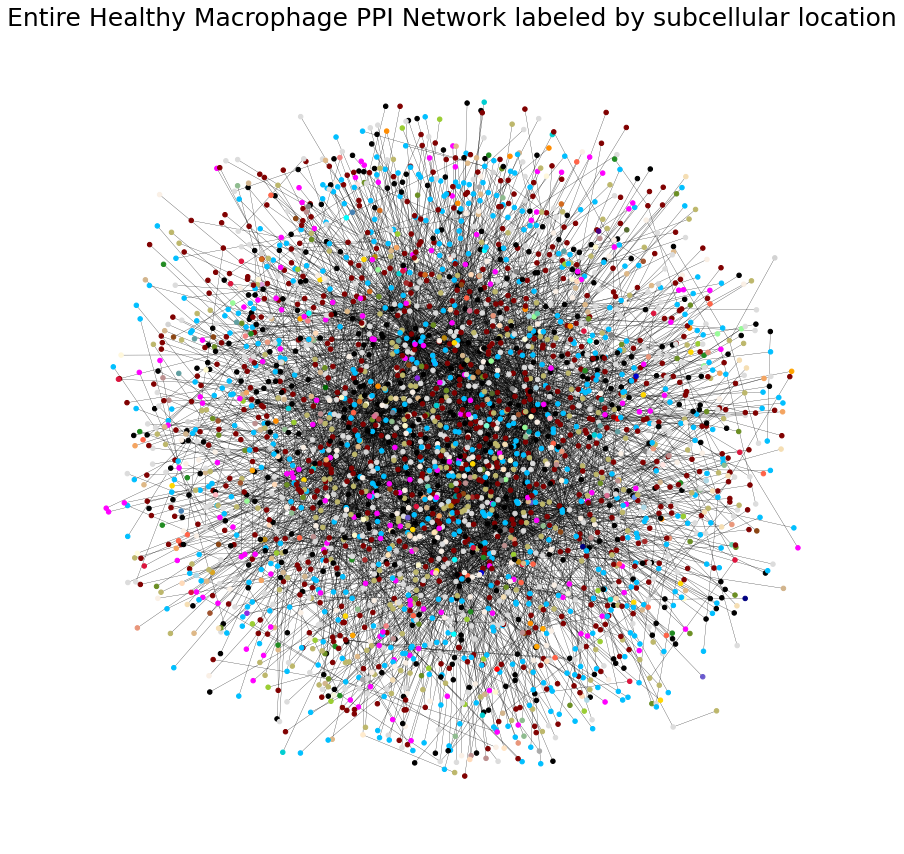

In [11]:
#Visualziing the healthy network

#set fig dimensions
diseased_whole_labeled, ax = plt.subplots(figsize =(15,15))

#setting x and y coordinates for nodes and edges
pos = nx.spring_layout(GX, iterations=20, k = 0.07, seed = 15)

#setting color map for attributes.
color_map =[]
for node in GX.nodes():
    location = GX.nodes[node]['Subcellular_location_[CC]']
    color_map.append(color_dict[location])
 
        
#Draw nodes w/ color map
nx.draw_networkx_nodes(GX, 
                       pos, 
                       node_size=20,
                       alpha = 1,
                       nodelist = GX.nodes(),
                       node_color = color_map,
                      )


#Draw Edges        
nx.draw_networkx_edges(GX, pos, width=0.25)

ax.set_facecolor('white')
ax.axis('off')

#Plot Labels
name = "Entire Healthy Macrophage PPI Network labeled by subcellular location"
plt.title((name), fontdict = {'fontsize': 25, "color":'black'})
#plt.legend(scatterpoints=1)
plt.show()

#healthy_whole_labeled.savefig("../Plots/Entire_Macrophage_PPI_network_diseaselabeled.jpg", dpi = 300)

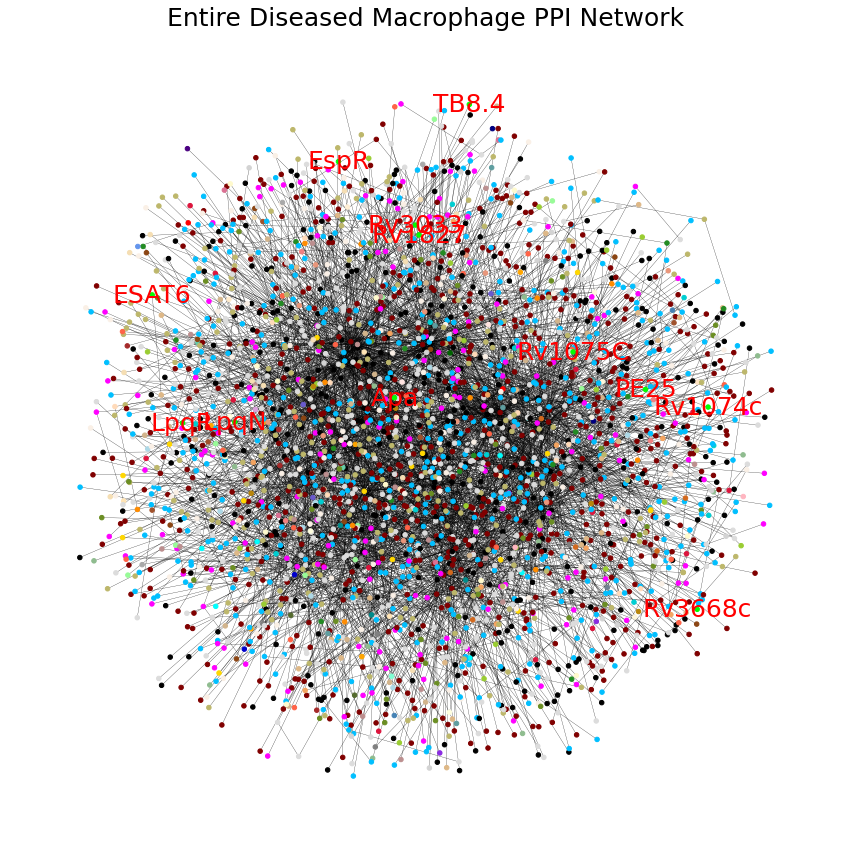

In [12]:
#Visualizing the diseased network with nodes colored by their subcellular location
"""This cell will not run until the cell that compiles Mtb_proteins has been run downstream of this"""

#set fig dimensions
diseased_whole_labeled, ax = plt.subplots(figsize =(15,15))

#setting x and y coordinates for nodes and edges
pos = nx.spring_layout(GZ, iterations=20, k = 0.07, seed = 15)

#setting color map for attributes.
color_map =[]
for node in GZ.nodes():
    location = GZ.nodes[node]['Subcellular_location_[CC]']
    if node in Mtb_proteins:
        color_map.append('lime')
    else:
        color_map.append(color_dict[location])
 
        
#Draw nodes w/ color map
nx.draw_networkx_nodes(GZ, 
                       pos, 
                       node_size=20,
                       alpha = 1,
                       nodelist = GZ.nodes(),
                       node_color = color_map,
                      )


#create dict labels for mtb nodes:
labels_to_add = {}
for node in Mtb_proteins:
    labels_to_add[node] = node

nx.draw_networkx_labels(GZ,
                        pos,
                        labels = labels_to_add,
                       font_size = 25,
                        font_color="red")

#Draw Edges        
nx.draw_networkx_edges(GZ, pos, width=0.25)

ax.set_facecolor('white')
ax.axis('off')

#Plot Labels
name = "Entire Diseased Macrophage PPI Network"
plt.title((name), fontdict = {'fontsize': 25, "color":'black'})
#plt.legend(scatterpoints=1)
plt.show()

#diseased_whole_labeled.savefig("../Plots/Entire_Macrophage_PPI_network_diseaselabeled.jpg", dpi = 300)


Here we can see that our networks are quite noisy, and its difficult to note anything of importance just from looking at these. 

To begin comparing these networks, we will first start with a centrality analysis.

First we will calculate the centrality scores for each of the three measures described above for both the healthy and diseased graph**

In [13]:
#Centrality measures for Healthy Graph:
#Degree
degree_centralities_healthy = nx.degree_centrality(GX)
#Betweenness
betweenness_centralities_healthy = nx.betweenness_centrality(GX)    
#Closeness
closeness_centralities_healthy = nx.closeness_centrality(GX)

#--------------------------------------------

#Centrality measures for Diseased Graph
#Degree
degree_centralities_diseased = nx.degree_centrality(GZ)
#Betweenness
betweenness_centralities_diseased = nx.betweenness_centrality(GZ)    
#Closeness
closeness_centralities_diseased = nx.closeness_centrality(GZ)


In [14]:
#Sort the dictionaries created above so that the highest central nodes for each measure are at the beginning of the dictionaries

#Sorted Healthy:
#Degree
degree_centralities_healthy_sorted = dict(sorted(degree_centralities_healthy.items(), reverse = True, key=lambda x:x[1]))
#Betweenness
betweenness_centralities_healthy_sorted = dict(sorted(betweenness_centralities_healthy.items(), reverse = True, key=lambda x:x[1]))    
#Closeness
closeness_centralities_healthy_sorted = dict(sorted(closeness_centralities_healthy.items(), reverse = True, key=lambda x:x[1]))

#--------------------------------------------

#Sorted Diseased
#Degree
degree_centralities_diseased_sorted = dict(sorted(degree_centralities_diseased.items(), reverse = True, key=lambda x:x[1]))
#Betweenness
betweenness_centralities_diseased_sorted = dict(sorted(betweenness_centralities_diseased.items(), reverse = True, key=lambda x:x[1]))
#Closeness
closeness_centralities_diseased_sorted = dict(sorted(closeness_centralities_diseased.items(), reverse = True, key=lambda x:x[1]))

Now we can begin our comparison. First, lets just compare some standard features of our graphs

In [15]:
#print some stats

#Healthy
graphfeatures(GX)
print('\n')
#Diseased
graphfeatures(GZ)

Graph named 'Healthy Network' with 3057 nodes and 4733 edges
General graph features = None
Graph not connected, no graph center can not be calculated
Graph not connected, Diameter can not be calculated
Graph not connected, Radius can not be calculated
The Average Degree of our network is 1.55. The average degree of a network refers to the average number of edges that exist for each node.
The Density of our graph is 0.001. Density is a measure of how many ties between nodes exist compared to how many are possible.
The average clustering coefficient of our graph is 0.0091. The clustering coefficient ranges from 0-1 and is a measure of the ratio of connections for each node observed versus what is possible 
Is the graph fully connected? False
Number of connected components = 22
Number of isolates = 0


Graph named 'Diseased Network' with 3069 nodes and 4755 edges
General graph features = None
Graph not connected, no graph center can not be calculated
Graph not connected, Diameter can not 

As we would expect, not much has changed with major graph features when we simply add in the Mtb pathogen interations (22 in our case). The graph degree stays the same at 1.55, meaning each protein on average has 1.5 connections. Our graphs are fairly sparse, with low densities of 0.001, as is common for protein-protein interaction networks.

Next we will compare which nodes are central across measures of centrality as well between graphs

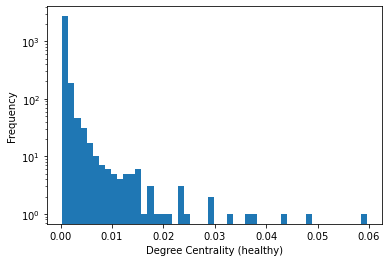

In [16]:
#First examine the distribution of centrality scores for the healthy graph:
centrality_distrib_plot(degree_centralities_healthy_sorted,'Degree Centrality (healthy)')

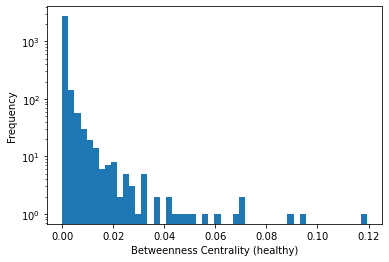

In [17]:
centrality_distrib_plot(betweenness_centralities_healthy_sorted,'Betweenness Centrality (healthy)')

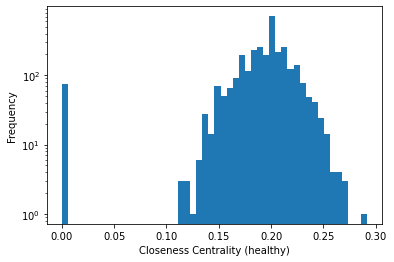

In [18]:
centrality_distrib_plot(closeness_centralities_healthy_sorted,'Closeness Centrality (healthy)')

From this we can see that there is quite a large distribution for each of the three measures. There appears to be about 10 nodes which display very high central scores relative to the other nodes when looking at degree and betweenness centrality. The distribution for closeness centrality is indicative of what we would expect to see as we traverse from one side of the network to the other, with the nodes 'in the middle' being the closest to all others.

Next we would like to know what are the central nodes in our network? To do this we will look at the top 5% of central nodes for each the measures and determine which nodes are central in more than one way - in other words, which hubs are also bottlenecks?

In [19]:
#Compile dictionaries of top 5% percent of nodes for each of the centrality scores
top5_degree_healthy = percentile_puller(degree_centralities_healthy_sorted,5)
top5_betweenness_healthy = percentile_puller(betweenness_centralities_healthy_sorted,5)
top5_closeness_healthy = percentile_puller(closeness_centralities_healthy_sorted,5)

#Do the same for the diseased network while we are at it
top5_degree_diseased = percentile_puller(degree_centralities_diseased_sorted,5)
top5_betweenness_diseased = percentile_puller(betweenness_centralities_diseased_sorted,5)
top5_closeness_diseased = percentile_puller(closeness_centralities_diseased_sorted,5)

In [20]:
#examine for sample
top5_degree_healthy
#top5_betweenness_healthy
#top5_closeness_healthy

{'P16401': 0.05955497382198953,
 'Q9H257': 0.047774869109947646,
 'Q02930': 0.043520942408376964,
 'Q8NEC5': 0.03763089005235602,
 'Q8NI38': 0.03664921465968587,
 'Q13422': 0.03304973821989529,
 'P08631': 0.029450261780104715,
 'O95231': 0.02879581151832461,
 'P30273': 0.025196335078534034,
 'Q9P2A4': 0.023887434554973823,
 'P19397': 0.023887434554973823,
 'P59046': 0.02356020942408377,
 'O43586': 0.0206151832460733,
 'P04271': 0.01963350785340314,
 'Q07325': 0.01897905759162304,
 'P01375': 0.01767015706806283,
 'Q9Y4H4': 0.017342931937172776,
 'P54852': 0.017015706806282723,
 'Q9BXN2': 0.016361256544502618,
 'Q8TB24': 0.015706806282722516,
 'P43405': 0.015379581151832461,
 'P41220': 0.015379581151832461,
 'Q96FZ5': 0.015379581151832461,
 'Q92608': 0.014725130890052358,
 'Q6XD76': 0.014725130890052358,
 'Q9HC29': 0.014397905759162305,
 'P35408': 0.0137434554973822,
 'P32121': 0.0137434554973822,
 'Q96MF2': 0.013416230366492147,
 'P07948': 0.013416230366492147,
 'O14526': 0.013089005235

In [21]:
#Which nodes are present in all three lists?

in_all_three = []
for node in top5_degree_healthy.keys():
    if node in top5_betweenness_healthy.keys():
        if node in top5_closeness_healthy.keys():
            in_all_three.append(node)

print("Number of nodes found to be central across all measures: ",len(in_all_three))
print(in_all_three)

Number of nodes found to be central across all measures:  69
['P16401', 'Q9H257', 'Q02930', 'Q8NEC5', 'Q8NI38', 'Q13422', 'P08631', 'O95231', 'P30273', 'Q9P2A4', 'P59046', 'O43586', 'P04271', 'Q07325', 'P01375', 'Q9Y4H4', 'P54852', 'Q8TB24', 'P43405', 'P41220', 'Q96FZ5', 'Q6XD76', 'Q9HC29', 'P07948', 'O14526', 'P27918', 'Q8N386', 'Q8NF50', 'Q9HBI0', 'P26951', 'O60711', 'Q7L591', 'P29350', 'Q96QH2', 'Q9NR55', 'P05107', 'P26447', 'O60603', 'P15498', 'Q13094', 'P12314', 'Q06187', 'P20138', 'Q8N6G5', 'P41218', 'P02545', 'P31146', 'P29466', 'P42768', 'Q6P1J6', 'Q9BRR9', 'P00533', 'P62993', 'P78324', 'P50222', 'Q6ZNE9', 'Q6A162', 'O75031', 'P63000', 'O15117', 'P05067', 'Q15323', 'A8MQ03', 'P01023', 'P08238', 'Q8TAP4', 'Q8TAF8', 'Q7Z699', 'P46108']


Now that we know what the central nodes are in our network, we can see if the addition of Mtb diplaces any of these central nodes. In other words, do any of the Mtb nodes appear in the top 5% of central nodes, OR do any of the Mtb nodes interact with a node that is already central?

In [22]:
#Compile list of MTB nodes for reference
Mtb_proteins = []
for node in GZ.nodes():
    if GZ.nodes[node]["Pathway"] == "Mtb":
        Mtb_proteins.append(node)
#examine
print(Mtb_proteins)

['Rv3033', 'LpqN', 'Apa', 'LpqR', 'ESAT6', 'PE25', 'Rv3668c', 'TB8.4', 'Rv1827', 'EspR', 'Rv1075C', 'Rv1074c']


In [23]:
#Checking if Mtb proteins appear in the top 5% percent of central nodes
counter = 0
for prot in Mtb_proteins:
    if prot in top5_degree_diseased.keys():
        print(str(prot),"is in the top 5% of degree")
        counter += 1
    if prot in top5_betweenness_diseased.keys():
        print(str(prot),"is in the top 5% of betweenness")
        counter += 1
    if prot in top5_closeness_diseased.keys():
        print(str(prot),"is in the top 5% of closeness")
        counter += 1
if counter == 0:
    print("Mtb was not found to be within the top 5% of central nodes for any of the three measures")
else:
    print("Mtb was found in at least one of the 3 top5% lists.")
    

Mtb was not found to be within the top 5% of central nodes for any of the three measures


In [24]:
#Are the top nodes for the diseased network still the same as the healthy network?

def percentsame(diseased,healthy): #dict1=diseased dict2=healthy
    counter = 0
    nodes=[]
    total = len(healthy.keys())
    for node in healthy.keys():
        if node in diseased.keys():
            counter += 1
        else:
            nodes.append(node)
    rounded = round(((counter/total)*100),3)
    percent = str(rounded)
    frac = str(counter)+str("/")+str(total)
    print(percent,"% of the diseased central nodes were amongst the healthy central nodes",frac)
    return(nodes)
#-------------------------------------------------------
#Check degree
print('For degree central:')
p1 = percentsame(top5_degree_diseased,top5_degree_healthy)
print(p1)
print('\n')

#Check betweenness
print('For betweenness central:')
p2=percentsame(top5_betweenness_diseased,top5_betweenness_healthy)
print(p2)
print('\n')

#Check closeness
print('For closeness central:')
p3=percentsame(top5_closeness_diseased,top5_closeness_healthy)
print(p3)

For degree central:
100.0 % of the diseased central nodes were amongst the healthy central nodes 161/161
[]


For betweenness central:
99.346 % of the diseased central nodes were amongst the healthy central nodes 152/153
['O14843']


For closeness central:
100.0 % of the diseased central nodes were amongst the healthy central nodes 153/153
[]


From this we can tell that only 1 node was not present in the original list of central nodes within the healthy network. This node "014843" got slightly displaced as the result of changes in centrality and fell just out of the top 5% range. With nothing major standing out here, we will move on to our next question which is - are any of the mtb direct targets found within the list of most central nodes?

In [25]:
#Checking if Mtb directly targets any of the top 5% central nodes

#First compile all mtb edges
Mtb_edges = []
Mtb_direct_targets = []
for edge in GZ.edges():
    if edge[0] in Mtb_proteins or edge[1] in Mtb_proteins:
        Mtb_edges.append(edge)
        #also compile Mtb direct targets while we are at it
        if edge[0] in Mtb_proteins:
            Mtb_direct_targets.append(edge[1])
        if edge[1] in Mtb_proteins:
            Mtb_direct_targets.append(edge[0])
        
Mtb_edges = tuple(Mtb_edges)
Mtb_direct_targets = list(set(Mtb_direct_targets))

#quick check
#print(len(Mtb_edges))
#print(len(Mtb_direct_targets))

def targetchecker(Mtb_direct_targets,dct):
    counter = 0
    nodes = []
    for target in Mtb_direct_targets:
        if target in dct.keys():
            counter+=1
            nodes.append(target)
    print(str(counter),"of the Mtb proteins have direct interactions with central nodes")
    return(nodes)
            

#check if mtb targets are in top 5% of central nodes
#Check degree
print('For degree central:')
t1 = targetchecker(Mtb_direct_targets,top5_degree_healthy)
print(t1)
print('\n')

#Check betweenness
print('For betweenness central:')
t2= targetchecker(Mtb_direct_targets,top5_betweenness_healthy)
print(t2)
print('\n')

#Check closeness
print('For closeness central:')
t3= targetchecker(Mtb_direct_targets,top5_closeness_healthy)
print(t3)

For degree central:
1 of the Mtb proteins have direct interactions with central nodes
['Q7L591']


For betweenness central:
1 of the Mtb proteins have direct interactions with central nodes
['Q7L591']


For closeness central:
4 of the Mtb proteins have direct interactions with central nodes
['Q15654', 'Q7L591', 'Q16543', 'P22681']


From this we can see that the human protein Q7L591, which is central by all three measures, is being attacked by MTB. Looking at this protein, its Uniprot name is DOK3 and its a docking protein with the following description: "DOK proteins are enzymatically inert adaptor or scaffolding proteins. They provide a docking platform for the assembly of multimolecular signaling complexes. DOK3 is a negative regulator of JNK signaling in B-cells through interaction with INPP5D/SHIP1. May modulate ABL1 function (By similarity)"

Next, let's identify which Mtb protein is responsible for binding to this protein.

In [26]:
for edge in Mtb_edges:
    if 'Q7L591' in edge:
        print(edge)

('Q7L591', 'Apa')


Hee we can see that Apa is the protein that binds to one of the most central proteins in our network. Next we will visualize the interaction.

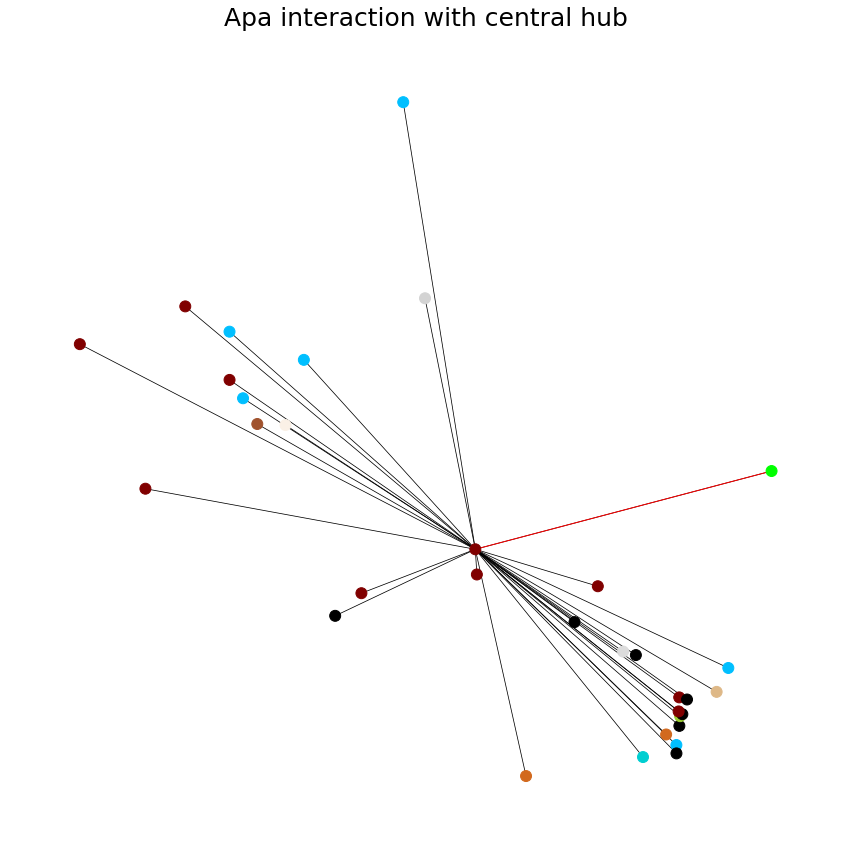

In [27]:
#Graphing Apa interaction with Q7L591 

#First get all direct neighbor edges of target:Q7L591
target_nodes = list(nx.neighbors(GZ,'Q7L591'))
target_nodes.append('Q7L591')

target_edges = []
for edge in GZ.edges():
    if 'Q7L591' in edge:
        target_edges.append(edge)



#set fig dimensions
Apa_interaction, ax = plt.subplots(figsize =(15,15))

#setting x and y coordinates for nodes and edges
pos = nx.spring_layout(GZ, iterations=20, seed = 15)

#setting color map for subcellular location, APA will be labeled lime green
color_map =[]
for node in target_nodes:
    if node in Mtb_proteins:
        color_map.append('lime')
    else:
        color_map.append(color_dict[GZ.nodes[node]['Subcellular_location_[CC]']])
    
 
#Draw nodes w/ color map
nx.draw_networkx_nodes(GZ, 
                       pos, 
                       node_size=120,
                       alpha = 1,
                       nodelist = target_nodes, 
                       node_color = color_map
                      )


#Draw Edges        
apa_edge = [('Q7L591', 'Apa')]
nx.draw_networkx_edges(GZ, pos, edgelist=target_edges, edge_color='black', width = 0.75)
nx.draw_networkx_edges(GZ, pos, edgelist=apa_edge, edge_color='red', width = 1)


ax.set_facecolor('white')
ax.axis('off')

#Plot Labels
name = "Apa interaction with central hub"
plt.title((name), fontdict = {'fontsize': 25, "color":'black'})
#plt.legend(scatterpoints=1)

plt.show()
#sub_mtb_louvain_community.savefig("../Plots/sub_disease_louvain_plot.jpg")

Here we can see in lime green the Apa mtb protein attacking the DOK3 central protein, which appears to be a hub. 

### Conclusions:

With the largest take away so far being that the Apa mtb protein seems to interact with one of the top 5% most central nodes in the network, there isn't much else to discern from looking at the entire network due to the amount of noise. It appears that aside from that one protien interaction, the effects of MTB are more subtle and will require further analysis on the subnetwork scale which we will explore in the next notebook. For now we will keep in mind the importance of Apa in this system and move into our community analysis.

# **Community Analysis**

## **Introduction** - Understanding Communities

In network science, communities can generally be defined as locally dense connected subgraphs. That is to say, all nodes of a community must be accessible through other nodes of the same community. The existence of communities within a network relies upon the connectedness and density hypotheses, which assumes that (1) if a network consists of two isolated components, each community is limited to only one component. The hypothesis also implies that on the same component a community cannot consist of two subgraphs that do not have a link to each other; and (2)Nodes in a community are more likely to connect to other members of the same community than to nodes in other communities. 

The challenge of detecting communities in protein networks lies in the fact that both the number and size of communities are unknown, unlike in methods of graph partitioning, where these parameters are given. The relationship between a network size and the number of possible, unique partitions is represented as Dobinski's formula: 

$$B_N=\frac{1}{e}\sum\limits_{j = 0}^\infty  {\frac{{j^N }}{{j!}}}$$


Where $B_N$ is the Bell number count of all possible partitions in a set, indicating the number of possible partitions grows faster than exponentially with larger networks, making the problem NP-hard. 

In order to identify communities within our protein networks, we will be implementing a variety of algorithms described below.

## Overview of Implemented Community Detection Algorithms:

## **The Louvain Algorithm**

When we assume the hypothesis that a randomly wired network lacks inherent community structure, any systematic deviation from that random configuration becomes meaninfgul, and if measured, allows for comparisons to be made in the quality of network partitions. This measurment called modularity can be written as:




$$M_c=\frac{{L_c }}{L}-\left({\frac{{k_c }}{{2L}}}\right)^2$$


where L is the number of links in the graph, L<sub>c </sub> is the total number of links within the proposed community, and k<sub>c </sub> is the total degree of the nodes in this community.

This measure, when summed over all n<sub>c</sub> identified communuties, represents the partition's modularity and can be defined as:




$$M=\sum\limits_{c=1}^{n_c }{\left[{\frac{{L_c}}{L}-\left({\frac{{k_c}}{{2L}}}\right)^2}\right]}$$

This value can range from -1/2 to 1, where 0 would indicate the whole network is a single community. If each node belonged to a separate community, then L<sub>c</sub> would be 0 and the resulting M value would be negative. Since M is a fractional measure of the difference between the observed and expected number of edges, paritions with a higher M should indicate that those paritions more accurately capture the true community structure.  

Indeed, the Maximal Modularity Hypothesis, which states that "For a given network the partition with maximum modularity corresponds to the optimal community structure", is the basis for the Louvain algorithm. The Louvain algorithm is a greedy, agglomerative algorithm which uses a two-part iterative process broken into modularity optimization and community aggregation. To start, the algorithm labels each node as its own community. It then optimizes for modularity by reassigning nodes to neighboring communities only if the calculated difference in modularity is positive. This step is repeated until maximal modularity has been reached. In the community aggregation step, each community is reassigned as a super-node with a self-loop containing all its within-community edges, and the super-nodes are then treated as a new network, where the modularity optimization can be reapplied. This iterative process yields a hierarchical organization of communities.

The Louvain algorithm is fast, and scales to large networks due to its use of a heuristic in order to reduce the computational complexity associated with the NP-hard problem of optimizing modularity within a network. 

## **The FastGreedy Algorithm**

Similar to the Louvain algoritmh, the FastGreedy Algorithm uses a bottom-up agglomerative approach, based on optimizing modularity, $M$, to identify community partitions. The advantage of the FastGreedy algorithm lies in its speed, as it was modified with sparse graphs in mind. Sparse graphs are those in which there are far fewer edges observed than edges possible given a set of nodes, and is often a characteristic feature of protein networks. When communities are merged together during the heirarchical clustering process, pairs of rows and columns within the adjacency matrices are merged together, but since many of those rows and columns contain zeros in sparse graphs, much of the computational power allocated to agglomerative algorithms is wasted on the empty regions of the graph. This algorithm improves both memory utilization and speed by altering the data structures such that rather than storing the adjaceny matrix in memory and calculating the $\Delta M$ each time, it instead stores, and updates a matrix of $\Delta M$  values, eliminating the storage of any communities that aren't connected by at least one edge. The algorithm also utilizes a data structure to store the largest $\Delta M$, reducing computational time associated with computing changes in modularity, and allowing for a faster-than-average runtime of essentially O($\textit{n}$ log$^2$ $\textit{n}$) for sparse graphs, where n is the number of nodes.

## **The Edge-Betweenness Algorithm**

Unlike in Agglomerative algorithms where the starting assumption is that each node is its own community, divisive algorithms begin with the opposing assumption that the entire network is a community, and systematically removes the links connecting nodes that belong to different communities until the network is broken into its sub-partitions. To accomplish this, these algorithms use a different measure, called centrality to determine which nodes belong to each community.

The Edge-Betweenness algorithm, also called the Girvan-Newman Algorithm, systematically prunes edges that are least central, or are most "between" communities, until the resulting graph is fully partitioned. The Edge-Betweenness algorithm uses a defintion of centrality described as the number of shortest paths running through the given edge, and serves as measure of the edge's influence over the flow of information in the network. There are four main steps this algorithm carries out and are described as follows.

The first step is to calculate the betweeneness for all edges in the network. This calculation can be represented as:

$$g(\upsilon) = \sum_{s\neq\upsilon\neq t} \frac{\sigma_{\textit{st}}(\upsilon)}{\sigma_{\textit{st}}}$$

where $\sigma_{st}$ represents the total number of shortest paths from node $\textit{s}$ to node $\textit{t}$ and $\sigma_{\textit{st}}$ represents the number of those paths that have an edge passing through node $\upsilon$. After computing the edge-betweenness value for each node pair in the network, those edges with the highest values are pruned, creating network partitions. The algorithm then recalculates the betweenness centrality for all edges affected by the pruning, and repeats this process of pruning, followed by a recalculation, until no edges remain. On sparse graphs, the algorithm runs in time $O(n^{3})$ due to the computationally difficulty associated with calculating edge-betweenness for each pair of nodes in the network at each iteration, making this algorithm the slowest that we will apply.

## **The WalkTrap Algorithm**

 Lastly, we will also implement the WalkTrap Algorithm, which is another hierarchical clustering algorithm. The basic intuition applied in the WalkTrap Algorithm is that random walks from one node to another should get "trapped" into densely connected parts corresponding to communities. The algorithm defines a metric $\textit{r}$ used to measure the similarity of community structure between two nodes. This metric, $\textit{r}$, is a distance calculated from the set of all probabilities of a random walk connecting node $\textit{i}$ to node $\textit{j}$ in $\textit{t}$ steps, represented as $P_{\textit{ij}}^{\textit{t}}$.
The resulting value should be high for two nodes within the same community, and low for nodes that in different communities. 
Using these probabilities as the decisive metric, the algorithm then merges communities in a greedy fashion, based on minimizing the mean of the squared distances between each vertex and its community. This process is then repeated to form graph partitions.  

## Computing community structure

First we will run all of the algorithms for both the healthy and diseased network, constructing the dictionaries which contain the nodes as keys and the community labels as values.

In [28]:
#imports for communnity algorithms.
import community 
from cdlib import algorithms
from cdlib import readwrite
from networkx.algorithms.community import greedy_modularity_communities
import csv 

In [29]:
#This cell runs all of the community generators. Unblock the code to rerun objects (few hours to run)

# #########################################################################################
# #Louvain method
# #    This object returned is a dictionary containing the nodes of graph G as keys, 
# #    and the community number that node belongs to as the value

# #healthy
# healthy_louvain_raw = community.best_partition(GX, random_state=0) 
# #diseased
# diseased_louvain_raw = community.best_partition(GZ, random_state=0)

# ##########################################################################################
# #FastGreedy Method
# # The object returned is a list of sets of nodes, each for a different community

# #healthy
# healthy_fastgreedy_raw = list(greedy_modularity_communities(GX)) 
# #diseased
# diseased_fastgreedy_raw = list(greedy_modularity_communities(GZ)) 

# #############################################################################################
# #WalkTrap
# #  #The object returned is a NodeClustering object

# #healthy
# healthy_walktrap_raw = algorithms.walktrap(GX) 
# #diseased
# diseased_walktrap_raw = algorithms.walktrap(GZ) 

# ##############################################################################################
# #Edge_betweeness
# #  The object returned is a list of sets of nodes, each for a different community

# #healthy
# healthy_betweenness_raw = algorithms.girvan_newman(GX,level=1,)
# #diseased
# diseased_betweenness_raw = algorithms.girvan_newman(GZ,level=1,)

Now that we have the object created, let's standardize the format so that they keys = community assignment and the labels = sorted list of all nodes in that community

In [30]:
# # #Standardizing structure of community objects and saving them. Unblock this cell to rerun and resave

# #Changing structure of Louvain objects

# #healthy
# healthy_louvain  = louvain_reorganizer(healthy_louvain_raw)

# #diseased
# diseased_louvain = louvain_reorganizer(diseased_louvain_raw)

# #Sorting louvain objects   
# for key,value in healthy_louvain.items():
#     healthy_louvain[key] = sorted(value)
# for key,value in diseased_louvain.items():
#     diseased_louvain[key]=sorted(value)
    
# #Saving louvian objects
# #healthy
# with open("../Data/Community_Partitions/healthy_louvain.csv", "w") as file: 
#     writer = csv.writer(file)
#     for key, value in healthy_louvain.items():
#        writer.writerow(value)

# #diseased
# with open("../Data/Community_Partitions/diseased_louvain.csv", "w") as file: 
#     writer = csv.writer(file)
#     for key, value in diseased_louvain.items():
#        writer.writerow(value)


# #-------------------------------------------------------------------------------------------------
# #changing structure of Fastgreedy objects

# #healthy
# healthy_fastgreedy = {i:healthy_fastgreedy_raw[i] for i in range(len(healthy_fastgreedy_raw))} 
# #diseased
# diseased_fastgreedy = {i:diseased_fastgreedy_raw[i] for i in range(len(diseased_fastgreedy_raw))} 

# #Sorting fastgreedy objects   
# for key,value in healthy_fastgreedy.items():
#     healthy_fastgreedy[key] = sorted(value)
# for key,value in diseased_fastgreedy.items():
#     diseased_fastgreedy[key]=sorted(value)

# #Saving fastgreedy objects
# #healthy
# with open("../Data/Community_Partitions/healthy_fastgreedy.csv", "w") as file: 
#     writer = csv.writer(file)
#     for key, value in healthy_fastgreedy.items():
#        writer.writerow(value)

# #saving diseased
# with open("../Data/Community_Partitions/diseased_fastgreedy.csv", "w") as file: 
#     writer = csv.writer(file)
#     for key, value in diseased_fastgreedy.items():
#        writer.writerow(value)

# #-------------------------------------------------------------------------------------------------
# #Walktrap - no need to change, just save 
# readwrite.write_community_csv(healthy_walktrap_raw, "../Data/Community_Partitions/healthy_walktrap.csv")
# readwrite.write_community_csv(diseased_walktrap_raw, "../Data/Community_Partitions/diseased_walktrap.csv")

# #-----------------------------------------------------------------------------------------------------
# #Edge_betweeness- no need to change, just save
# readwrite.write_community_csv(healthy_betweenness_raw, "../Data/Community_Partitions/healthy_edgebetweenness.csv")
# readwrite.write_community_csv(diseased_betweenness_raw, "../Data/Community_Partitions/diseased_edgebetweenness.csv")


Now that we have the objects saved and in a standardized form, lets load them in and begin to compare between the healthy and diseased graphs as well as across algorithms.

In [31]:
#Loading in community structure objects and printing stats on them

#loading in all healthy partitions:
healthy_louvain = communityloader("../Data/Community_Partitions/healthy_louvain.csv")
healthy_fastgreedy = communityloader("../Data/Community_Partitions/healthy_fastgreedy.csv")
healthy_walktrap = communityloader("../Data/Community_Partitions/healthy_walktrap.csv")      
healthy_betweenness = communityloader("../Data/Community_Partitions/healthy_edgebetweenness.csv")

#Loading diseased partitions
diseased_louvain = communityloader("../Data/Community_Partitions/diseased_louvain.csv")
diseased_fastgreedy = communityloader("../Data/Community_Partitions/diseased_fastgreedy.csv")
diseased_walktrap = communityloader("../Data/Community_Partitions/diseased_walktrap.csv")      
diseased_betweenness = communityloader("../Data/Community_Partitions/diseased_edgebetweenness.csv")
 
#Printing stats for healthy partitions:
print("Healthy network partition stats:")
print("Communities detected by the Louvain algo = {}".format(len(list(healthy_louvain.keys()))))
print("Communities detected by the Fastgreedy algo = {}".format(len(list(healthy_fastgreedy.keys()))))
print("Communities detected by the Walktrap algo = {}".format(len(list(healthy_walktrap.keys()))))
print("Communities detected by the Girvan_newman (edge-betweenness) algo = {}".format(len(list(healthy_betweenness.keys()))))
print('\n')

#Printing stats for diseased partitions:
print("Diseased network partition stats:")
print("Communities detected by the Louvain algo = {}".format(len(list(diseased_louvain.keys()))))
print("Communities detected by the Fastgreedy algo = {}".format(len(list(diseased_fastgreedy.keys()))))
print("Communities detected by the Walktrap algo = {}".format(len(list(diseased_walktrap.keys()))))
print("Communities detected by the Girvan_newman (edge-betweenness) algo = {}".format(len(list(diseased_betweenness.keys()))))

#Also storing a restructured version of each community partition so that we also have a form where key=node and value = community assignment. 
#This will be useful for referencing nodes when coloring by community assignment.

#healthy partitions
healthy_louvain_nodes = partition_labeler(healthy_louvain)
healthy_fastgreedy_nodes = partition_labeler(healthy_fastgreedy)
healthy_walktrap_nodes = partition_labeler(healthy_walktrap)
healthy_betweenness_nodes = partition_labeler(healthy_betweenness)

#diseased partitions
diseased_louvain_nodes = partition_labeler(diseased_louvain)
diseased_fastgreedy_nodes = partition_labeler(diseased_fastgreedy)
diseased_walktrap_nodes = partition_labeler(diseased_walktrap)
diseased_betweenness_nodes = partition_labeler(diseased_betweenness)


Healthy network partition stats:
Communities detected by the Louvain algo = 47
Communities detected by the Fastgreedy algo = 49
Communities detected by the Walktrap algo = 150
Communities detected by the Girvan_newman (edge-betweenness) algo = 23


Diseased network partition stats:
Communities detected by the Louvain algo = 47
Communities detected by the Fastgreedy algo = 51
Communities detected by the Walktrap algo = 155
Communities detected by the Girvan_newman (edge-betweenness) algo = 23


From this we can see that across algorithms, there is a diversity of community sizes, with the walktrap parsing the most  . The Girvan newman (edge-betweenness) algorithm, which is a top-down algorithm displays the fewest communities identified at 23, with the walktrap displaying the most (150-155). With the louvain algorithm and fastgreedy algorithms being closer to each other in size, we will use the louvain and fastgreedy for our next in depth comparison. 

Next we will visualize our diseased graph with the community assignments to see if there are any clear patterns.

No handles with labels found to put in legend.


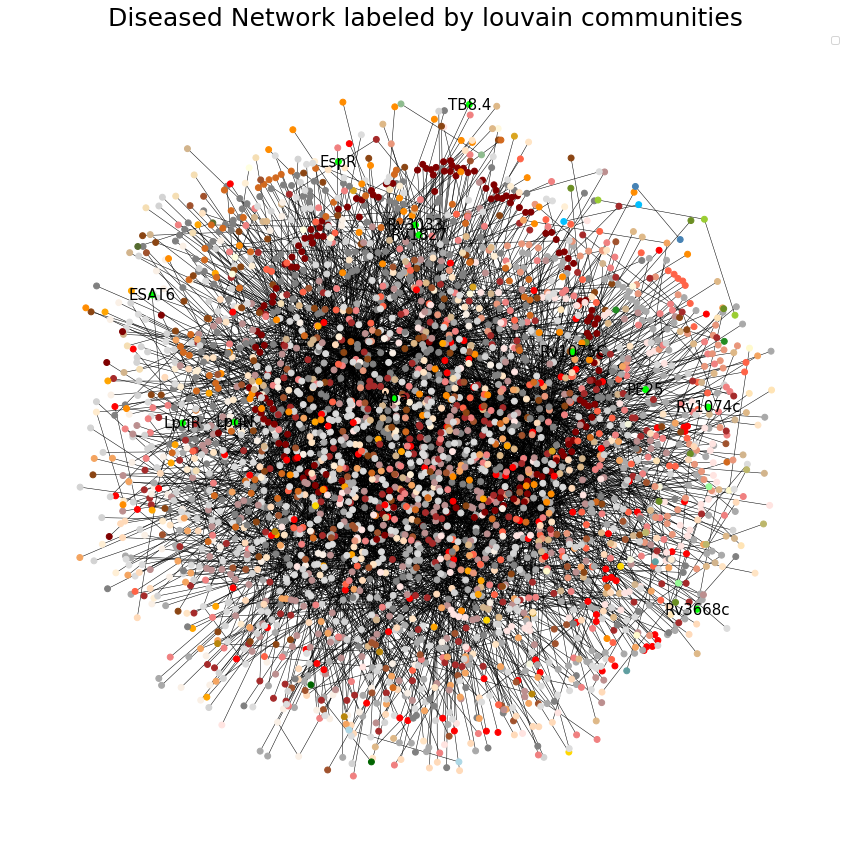

In [32]:
#Visualizing the diseased network labeled by louvain community. 

#set fig dimensions
diseased_labeled_louvain, ax = plt.subplots(figsize =(15,15))

#setting x and y coordinates for nodes and edges
pos = nx.spring_layout(GZ, iterations=20, k = 0.07, seed = 15)

#setting color map for attributes.
color_map =[]
for node in GZ.nodes():
    if node in Mtb_proteins:
        color_map.append('lime')
    else:
        num = diseased_louvain_nodes[node]
        color_map.append(numdict[num])
 
     
#Draw nodes w/ color map
nx.draw_networkx_nodes(GZ, 
                       pos, 
                       node_size=35,
                       alpha = 1,
                       nodelist = GZ.nodes(),
                       node_color = color_map,
                      )

#create dict labels for mtb nodes:
labels_to_add = {}
for node in Mtb_proteins:
    labels_to_add[node] = node

nx.draw_networkx_labels(GZ,
                        pos,
                        labels = labels_to_add,
                       font_size = 15,
                        font_color="black")

#Draw Edges        
nx.draw_networkx_edges(GZ, pos, width=0.5)

ax.set_facecolor('white')
ax.axis('off')

#Plot Labels
name = "Diseased Network labeled by louvain communities"
plt.title((name), fontdict = {'fontsize': 25, "color":'black'})
plt.legend(scatterpoints=1)
plt.show()

#diseased_whole_labeled_louvain.savefig("../Plots/Diseased_Network_louvain_labeled.jpg", dpi = 300)


As we might expect with a noisy network, there isn't much that is obvious to tell from the community assignments of these proteins.

Next we will print out some statistics pertaining to the node attributes that are found within each community. The purpose of this will be to determine if there is a clear pattern in types of nodes that are clustering together. I.e Do nodes within the same community have similar functions, locations, etc? we would expect so.

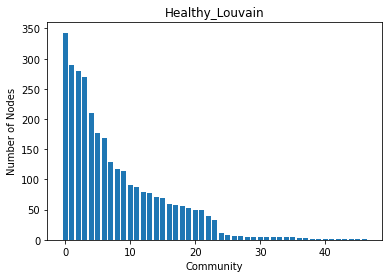

In [33]:
Community_distrib(healthy_louvain, "Healthy_Louvain")

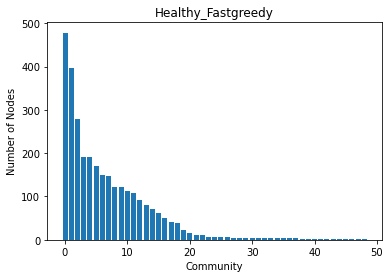

In [34]:
Community_distrib(healthy_fastgreedy, "Healthy_Fastgreedy")

Given these distributions of community sizes, lets restrict our viewing of the stats to just the first 20 communities which contain the most members.

In [35]:
#examine features for first 20 communities
#Comparing Community compositions between louvain and fastgreedy

#establish parameters to use for function, specifying which attrbutes to pull and which communities to look at
input_list = ['Subcellular_Locations', 'Cellular_Components', 'Molecular_Functions']
comm_list = [i for i in range(20)]

#printing stats for Louvain, storing master dict
healthy_louvain_breakdown = community_stats(healthy_louvain,GX,input_list,[1,2,3])

Breakdown of Subcellular_Locations by community
Community #: 1
Size: 	 289
Membrane 	 30.4%
Cell membrane 	 18.7%
Endoplasmic reticulum membrane 	 12.1%
Secreted 	 6.6%
Nucleus 	 4.2%
Cytoplasm 	 4.2%
Golgi apparatus membrane 	 3.1%
Mitochondrion 	 2.4%
Unknown 	 2.1%
Golgi apparatus 	 2.1%
Lysosome membrane 	 1.4%
Microsome membrane 	 1.0%
Nucleus inner membrane 	 1.0%
Mitochondrion inner membrane 	 1.0%
Cell junction 	 1.0%
Endosome membrane 	 0.7%
Host cell membrane 	 0.7%
Host nucleus 	 0.7%
Mitochondrion membrane 	 0.7%
Mitochondrion matrix 	 0.7%
Cytoplasmic vesicle 	 0.7%
Lysosome 	 0.3%
Late endosome membrane 	 0.3%
Microsome 	 0.3%
Apical cell membrane 	 0.3%
Vacuole membrane 	 0.3%
Host cytoplasm 	 0.3%
Mitochondrion outer membrane 	 0.3%
Cytoplasmic vesicle membrane 	 0.3%
Virion tegument 	 0.3%
Nucleus membrane 	 0.3%
Chromosome 	 0.3%
Early endosome membrane 	 0.3%
Peroxisome membrane 	 0.3%


Community #: 2
Size: 	 280
Nucleus 	 28.2%
Cytoplasm 	 27.5%
Unknown 	 25.7%
Cel

There isn't much that is obvious to take away from just looking at the breakdown of these functions, so instead let's take another approach. We can ask the question: "which communities changed as a result of the addition of Mtb?". We can answer this question by examining a heatmap of the before and after communities, and see which communities gained new members or lost some members.

In order to do this, we must first relabel the commmunity numbers such that the pre-mtb labels match what the post-mtb labels should be, since the clustering algorithms arbitrarily assign the labels.

Let's just look at louvain and fastgreedy partitions for now.

In [36]:
#First we will need to relabel the communites so that the pre-community label is consistent with equivalent 
# post-community label. In brief the function here identifies which community in the pre condition best matches the post community. 

#Relabel Louvain partitions
healthy_louvain_relabeled, diseased_louvain_relabeled = community_relabler(healthy_louvain,diseased_louvain)

#Relabel Fastgreedy partitions
healthy_fastgreedy_relabeled, diseased_fastgreedy_relabeled = community_relabler(healthy_fastgreedy,diseased_fastgreedy)

Now let's create the heatmaps.

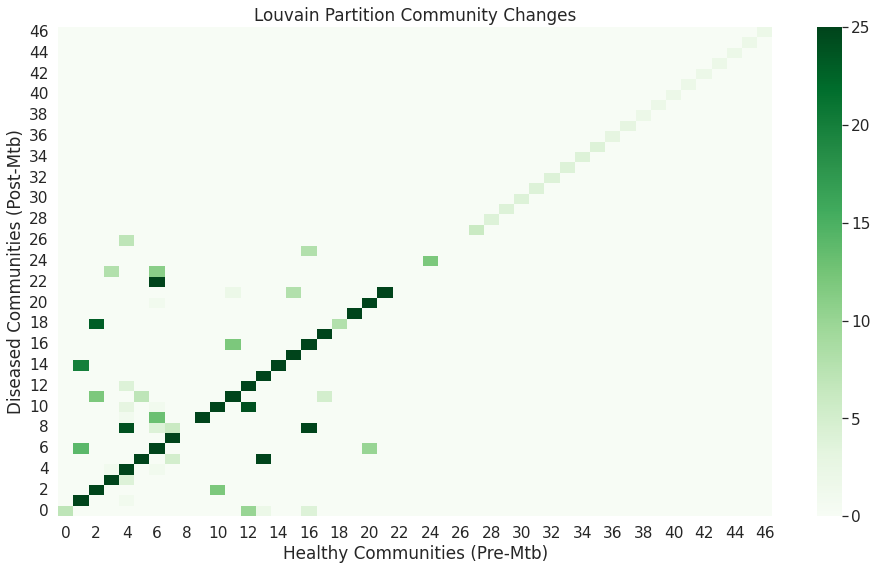

In [37]:
#Generate Louvain Heatmap
louvain_heatmap = community_heatmap(healthy_louvain_relabeled,diseased_louvain_relabeled,"Louvain Partition Community Changes")

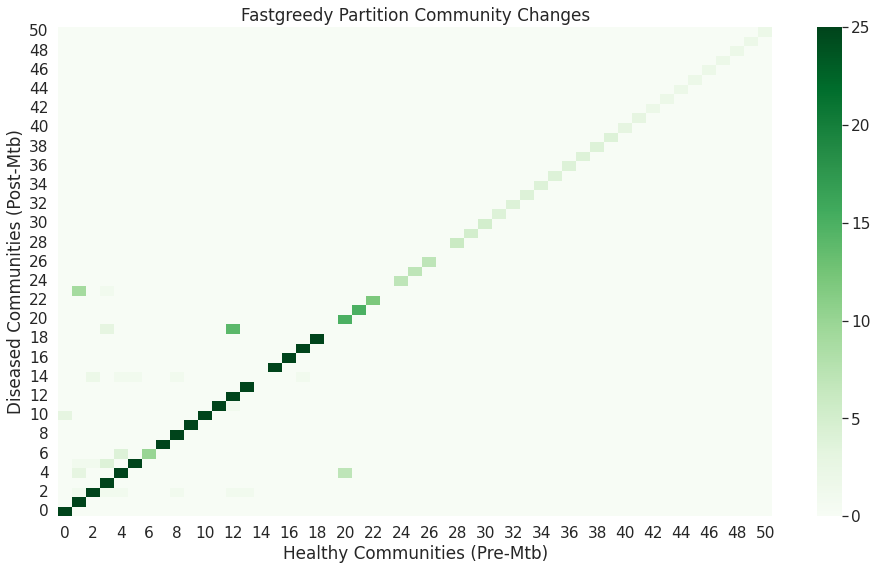

In [38]:
#Generate Fastgreedy Heatmap
fastgreedy_heatmap = community_heatmap(healthy_fastgreedy_relabeled,diseased_fastgreedy_relabeled,"Fastgreedy Partition Community Changes")

Looking at the first heatmap, it looks like there are a handful of communities which changed their composition with the addition of Mtb. It looks like that amongst the communites that shifted, 26, 25, and 8 were made of entirely new members. Communities 0,5, and 23 also displayed some large changes.

Looking at the changes associated with the fastgreedy partition, it appears that there were fewer changes in total, with the biggest changes being in communities 4,19, and 14.

First let's look at the communities 4,14,19,23 within the fastgreedy partition to try and understand what is going on.

In [39]:
#Communities of interest for Fastgreedy - 4,19,14,23

#establish parameters to use for function, specifying which attrbutes to pull and which communities to look at
input_list = ['nodes', 'Molecular_Functions']
comm_list = [4,14,19,23]

#printing stats for Louvain, storing master dict
diseased_fastgreedy_breakdown = community_stats(diseased_fastgreedy_relabeled,GZ,input_list,comm_list)

Breakdown of nodes by community
Community #: 4
Size: 	 195
A4FU69 	 0.5%
A4UGR9 	 0.5%
A6NCM1 	 0.5%
A6NJL1 	 0.5%
A8K855 	 0.5%
B5ME19 	 0.5%
EspR 	 0.5%
O14958 	 0.5%
O15090 	 0.5%
O15403 	 0.5%
O15440 	 0.5%
O43150 	 0.5%
O43680 	 0.5%
O43895 	 0.5%
O60383 	 0.5%
O60673 	 0.5%
O75094 	 0.5%
O75330 	 0.5%
O75351 	 0.5%
O75400 	 0.5%
O75844 	 0.5%
O75923 	 0.5%
O94811 	 0.5%
O94989 	 0.5%
O95425 	 0.5%
O95466 	 0.5%
O95922 	 0.5%
P04908 	 0.5%
P05154 	 0.5%
P05204 	 0.5%
P06930 	 0.5%
P09086 	 0.5%
P09565 	 0.5%
P10412 	 0.5%
P12956 	 0.5%
P13667 	 0.5%
P13725 	 0.5%
P13805 	 0.5%
P13994 	 0.5%
P15924 	 0.5%
P16401 	 0.5%
P16402 	 0.5%
P17096 	 0.5%
P19338 	 0.5%
P19474 	 0.5%
P20020 	 0.5%
P23588 	 0.5%
P24043 	 0.5%
P26583 	 0.5%
P27816 	 0.5%
P34931 	 0.5%
P35499 	 0.5%
P35548 	 0.5%
P35626 	 0.5%
P39019 	 0.5%
P40222 	 0.5%
P41223 	 0.5%
P43694 	 0.5%
P45973 	 0.5%
P46087 	 0.5%
P48067 	 0.5%
P48200 	 0.5%
P48645 	 0.5%
P49641 	 0.5%
P51828 	 0.5%
P52926 	 0.5%
P54198 	 0.5%
P5519

Right away from looking at the composition of communities 4, and 14, we can see that EspR and Apa, and the Rv- proteins are members of those new communities, indicating they have some noticeable influence on the network. We have already noticed that Apa is a potential important player in this network due to it's central role, and so next lets see if these players are also changing community structure within the louvain partition.

Looking at the louvain partition, the diseased communities which displayed the most re-clustering were #'s 0,5,6,8,10,11, 14, 21, and 23. Let's see if any Mtb proteins appear in those new communities.

In [40]:
#Checking louvain communities that have changed
#Communities of interest- 0,5,6,8,10,11,14,21, 23

#establish parameters to use for function, specifying which attrbutes to pull and which communities to look at
input_list = ['nodes']
comm_list = [0,5,6,8,10,11,14,21,23]

#printing stats for Louvain, storing master dict
diseased_lovain_breakdown = community_stats(diseased_louvain_relabeled,GZ,input_list,comm_list)

Breakdown of nodes by community
Community #: 0
Size: 	 341
A0A087WUL8 	 0.3%
A0PJX0 	 0.3%
A1E959 	 0.3%
A1KXE4 	 0.3%
A8MQ03 	 0.3%
A8MVS5 	 0.3%
B2RXF5 	 0.3%
O00167 	 0.3%
O14503 	 0.3%
O14867 	 0.3%
O14920 	 0.3%
O14936 	 0.3%
O15162 	 0.3%
O15321 	 0.3%
O15354 	 0.3%
O15496 	 0.3%
O43169 	 0.3%
O43597 	 0.3%
O43609 	 0.3%
O43665 	 0.3%
O43790 	 0.3%
O43791 	 0.3%
O60504 	 0.3%
O60663 	 0.3%
O60806 	 0.3%
O60936 	 0.3%
O75031 	 0.3%
O75344 	 0.3%
O75444 	 0.3%
O75525 	 0.3%
O75553 	 0.3%
O75711 	 0.3%
O75716 	 0.3%
O76003 	 0.3%
O76011 	 0.3%
O76036 	 0.3%
O76081 	 0.3%
O94929 	 0.3%
O95229 	 0.3%
O95231 	 0.3%
O95273 	 0.3%
O95416 	 0.3%
O95711 	 0.3%
O95967 	 0.3%
O95980 	 0.3%
P02652 	 0.3%
P02751 	 0.3%
P04141 	 0.3%
P05107 	 0.3%
P05113 	 0.3%
P05164 	 0.3%
P05187 	 0.3%
P06702 	 0.3%
P07498 	 0.3%
P07550 	 0.3%
P08151 	 0.3%
P08246 	 0.3%
P08311 	 0.3%
P08686 	 0.3%
P08700 	 0.3%
P08754 	 0.3%
P09471 	 0.3%
P0C6X7 	 0.3%
P0C746 	 0.3%
P0C7H8 	 0.3%
P10636 	 0.3%
P10745 	 0.3%

P31040 	 1.3%
P31751 	 1.3%
P32246 	 1.3%
P38432 	 1.3%
P43490 	 1.3%
P49770 	 1.3%
P49810 	 1.3%
P55160 	 1.3%
P62820 	 1.3%
Q00610 	 1.3%
Q00839 	 1.3%
Q00987 	 1.3%
Q01628 	 1.3%
Q04864 	 1.3%
Q05586 	 1.3%
Q13287 	 1.3%
Q13618 	 1.3%
Q15306 	 1.3%
Q16695 	 1.3%
Q16820 	 1.3%
Q53XC2 	 1.3%
Q5JR12 	 1.3%
Q5T7V8 	 1.3%
Q6NTF9 	 1.3%
Q6P1Q0 	 1.3%
Q70CQ1 	 1.3%
Q86UV7 	 1.3%
Q86VE9 	 1.3%
Q86W54 	 1.3%
Q8IYR6 	 1.3%
Q8TCQ1 	 1.3%
Q8TDY2 	 1.3%
Q8TEV9 	 1.3%
Q92793 	 1.3%
Q969Y2 	 1.3%
Q96ES6 	 1.3%
Q96LT7 	 1.3%
Q96MU7 	 1.3%
Q99714 	 1.3%
Q9BPX4 	 1.3%
Q9BXJ8 	 1.3%
Q9H3G5 	 1.3%
Q9H3N1 	 1.3%
Q9H8Y1 	 1.3%
Q9Y2M0 	 1.3%
Q9Y342 	 1.3%


Community #: 21
Size: 	 49
Apa 	 2.0%
O95478 	 2.0%
P00325 	 2.0%
P03129 	 2.0%
P04440 	 2.0%
P05787 	 2.0%
P06429 	 2.0%
P06430 	 2.0%
P06464 	 2.0%
P06465 	 2.0%
P06788 	 2.0%
P06932 	 2.0%
P08571 	 2.0%
P09629 	 2.0%
P10914 	 2.0%
P15328 	 2.0%
P24837 	 2.0%
P29033 	 2.0%
P36817 	 2.0%
P36827 	 2.0%
P50552 	 2.0%
P51617 	 2.0%
P52435 	 2.0%
P53618 	

With many more communities having shifted in the louvain partition, we see that Apa is in community 21, which is a composition of communities 11,15,and 21. We also see EspR in community 10, which is a composition of communities 4, 10, and 12. What we really want to know is are there communities with a distinct functional pattern that that Mtb is interacting with, and/or connecting. Given the amount of noise in this network, it is difficult to discern which changes are of biological importance. 

While we can see that the addition of Mtb leads to the clustering algorithms grouping nodes differently, to make any sense of this, we will need to zoom in on the network on a smaller scale to be able to make sense of the changes in community structure. From this analysis in total we have seen that **Apa** is the only Mtb protein that obviously stands out in this network, for its central role. We've also seen that Apa connects communities 11, and 15, which both contain many proteins that will require further analysis. We have also seen that a few other Mtb proteins including **EspR** and the **Rv** proteins are interacting with multiple communites and should also be further investigate for their role. 

The limitations of the analysis at this scale leads us into our next investigation, which will be network analysis of a similar method performed on a smaller subset of interactions. 

In our next notebook, we will look at the 2nd degree subnetwork of the all Mtb proteins, and their interactions within the macrophage.